In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '19'  # Adjust the number of threads as necessary

In [13]:
import networkx as nx
import numpy as np
import csv

# Function to build a weighted MultiGraph from a CSV file, excluding 'no_relation' edges
def build_multigraph_from_csv(csv_file):
    G = nx.MultiGraph()
    with open(csv_file, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            G.add_node(row['starter_ID'], name=row['starter_ID'])
            G.add_node(row['receiver_ID'], name=row['receiver_ID'])

            # Exclude 'no_relation' edges
            if row['relation_type'] != 'no_relation':
                weight = float(row['weight'])  # Assuming 'weight' column exists and is a float
                G.add_edge(
                    row['starter_ID'],
                    row['receiver_ID'],
                    weight=weight
                )
    
    return G

# Function to compute Katz similarity matrix
def compute_katz_similarity(G, beta=0.1, max_power=5):
    nodes = list(G.nodes())
    n = len(nodes)
    katz_matrix = np.zeros((n, n))
    I = np.eye(n)

    # Create weighted adjacency matrix
    A = nx.to_numpy_array(G, nodelist=nodes, weight='weight')

    for power in range(1, max_power + 1):
        katz_matrix += np.linalg.matrix_power(A, power) * beta**power
    katz_matrix += I

    return katz_matrix

# Build the multigraph and compute the Katz similarity matrix
csv_file_path = 'relations_train_final.csv'
MG = build_multigraph_from_csv(csv_file_path)
katz_similarity_matrix = compute_katz_similarity(MG)
katz_similarity_matrix_normalized = katz_similarity_matrix / np.max(katz_similarity_matrix)


Dimension Reduction
PCA

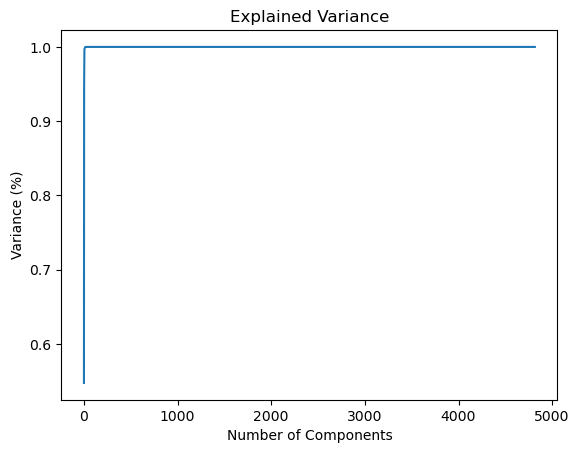

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming `data` is your data matrix
pca = PCA().fit(katz_similarity_matrix_normalized)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.title('Explained Variance')
plt.show()

Optimal number of components: 4


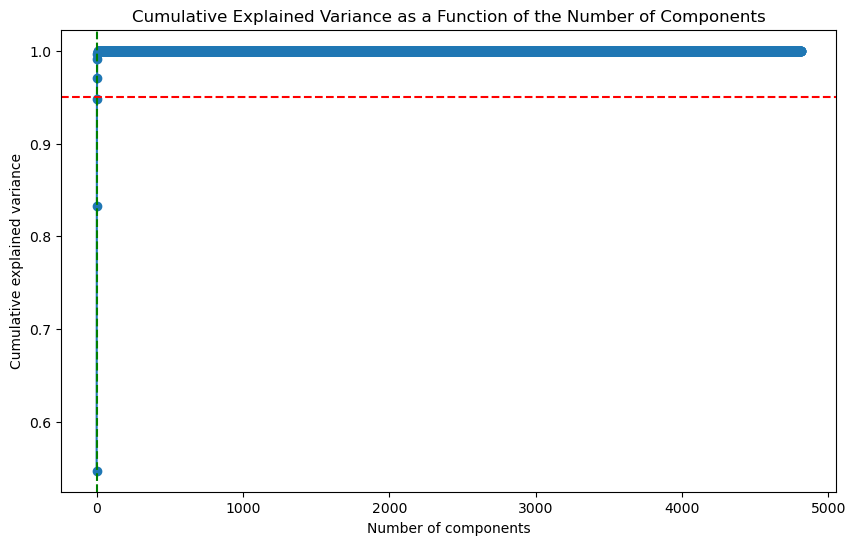

In [15]:
#SVD

import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Assume katz_similarity_matrix_normalized is your normalized Katz similarity matrix
matrix = katz_similarity_matrix_normalized

# Step 1: Perform SVD
n_components = min(matrix.shape)  # You can set this to the min number of rows/columns in your matrix
svd = TruncatedSVD(n_components=n_components)
svd.fit(matrix)

# Step 2: Calculate cumulative explained variance ratio
cumulative_var_ratio = np.cumsum(svd.explained_variance_ratio_)

# Step 3: Determine the optimal number of components
# You can adjust the threshold as needed
variance_threshold = 0.95
optimal_n_components = np.argmax(cumulative_var_ratio >= variance_threshold) + 1

# Print the optimal number of components
print(f"Optimal number of components: {optimal_n_components}")

# Plotting the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_var_ratio, marker='o')
plt.axhline(y=variance_threshold, color='r', linestyle='--')
plt.axvline(x=optimal_n_components, color='g', linestyle='--')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


c:\Users\ycy6y\.conda\envs\pathway_siamese_network\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


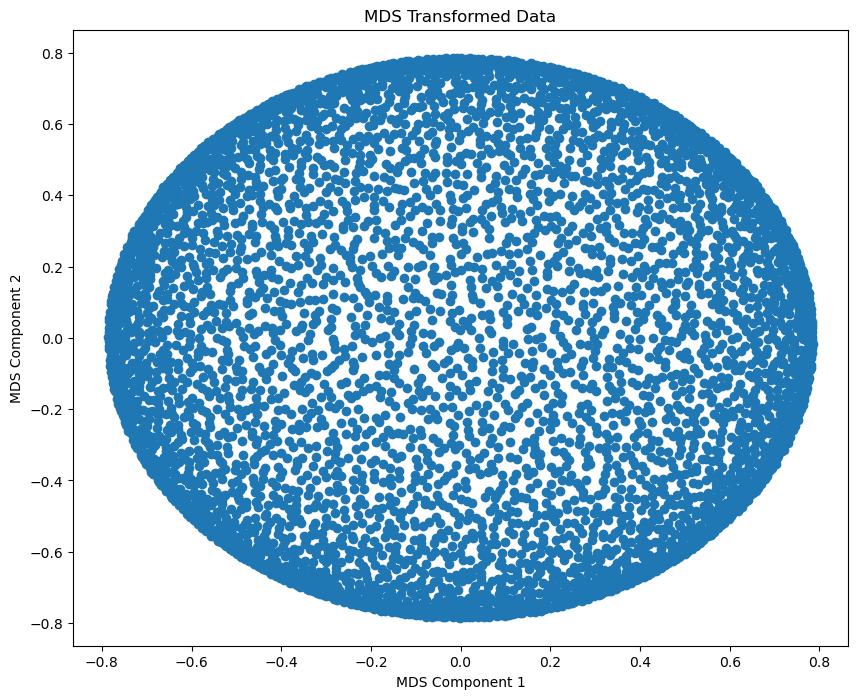

In [16]:
#MDS
from sklearn.manifold import MDS

# Assuming katz_similarity_matrix_normalized is your normalized Katz similarity matrix
matrix = katz_similarity_matrix_normalized

# Apply MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_transformed = mds.fit_transform(1 - matrix)  # Convert similarity to dissimilarity

# Visualizing the result
plt.figure(figsize=(10, 8))
plt.scatter(mds_transformed[:, 0], mds_transformed[:, 1])
plt.title('MDS Transformed Data')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.show()

Gene Pathway Relationships: In your case, where the graph represents gene pathways, the circular pattern might suggest that while MDS is preserving some local relationships (similar genes are close to each other), it struggles to accurately represent the global structure of the data in two dimensions.

Limitation in 2D Representation: This result emphasizes the limitations of representing complex, multi-dimensional gene pathway relationships in just two dimensions. Some subtleties and nuances might be lost or misrepresented.

In [17]:
#NMF
from sklearn.decomposition import NMF

# Assuming katz_similarity_matrix_normalized is your normalized Katz similarity matrix
matrix = katz_similarity_matrix_normalized

# Apply NMF
nmf = NMF(n_components=4, init='random', random_state=42)  # You can start with 4 components
W = nmf.fit_transform(matrix)
H = nmf.components_

# To determine the optimal number of components, we can look at the reconstruction error
reconstruction_error = nmf.reconstruction_err_

# Print the reconstruction error
print(f"Reconstruction Error with {nmf.n_components} components: {reconstruction_error}")

Reconstruction Error with 4 components: 0.7339849904901508


c:\Users\ycy6y\.conda\envs\pathway_siamese_network\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


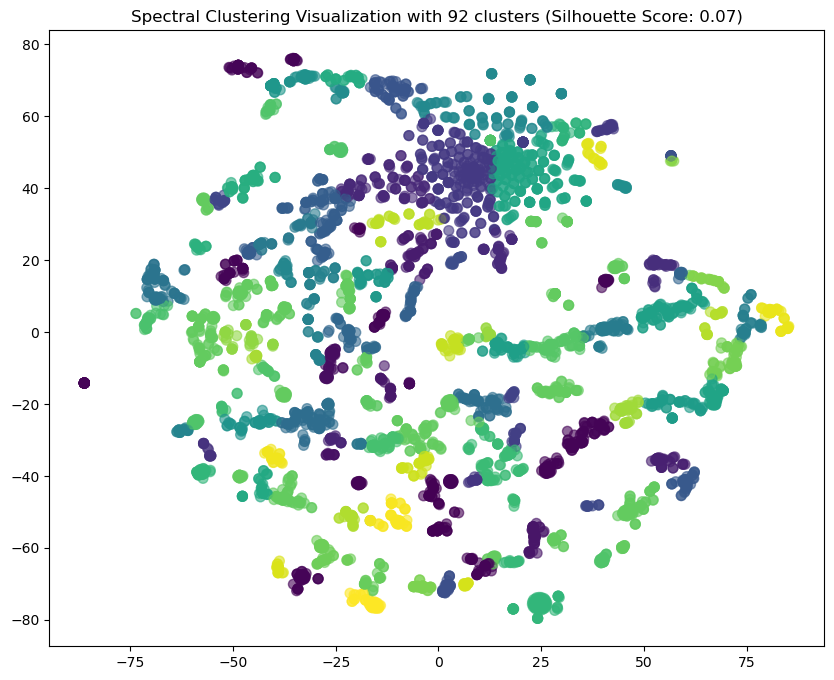

Spectral Clustering: Number of clusters = 92, Silhouette Score = 0.06742184609174728


In [42]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# Assuming katz_similarity_matrix_normalized is loaded

# Perform dimension reduction using t-SNE
tsne = TSNE(n_components=2)
reduced_data_tsne = tsne.fit_transform(katz_similarity_matrix_normalized)

# Function to apply clustering (Spectral Clustering) and visualize the result
def apply_spectral_clustering_and_visualize(reduced_data, n_clusters):
    # Apply Spectral Clustering
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    cluster_labels = clustering.fit_predict(reduced_data)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    
    # Visualize the clustering result
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.6)
    plt.title(f"Spectral Clustering Visualization with {n_clusters} clusters (Silhouette Score: {silhouette_avg:.2f})")
    plt.show()

    return n_clusters, silhouette_avg, cluster_labels

# Apply Spectral Clustering to t-SNE reduced data and visualize the result
n_clusters_spec, score_spec, labels_spec = apply_spectral_clustering_and_visualize(reduced_data_tsne, n_clusters=92)

# Output the result
print("Spectral Clustering: Number of clusters = {}, Silhouette Score = {}".format(n_clusters_spec, score_spec))

c:\Users\ycy6y\.conda\envs\pathway_siamese_network\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


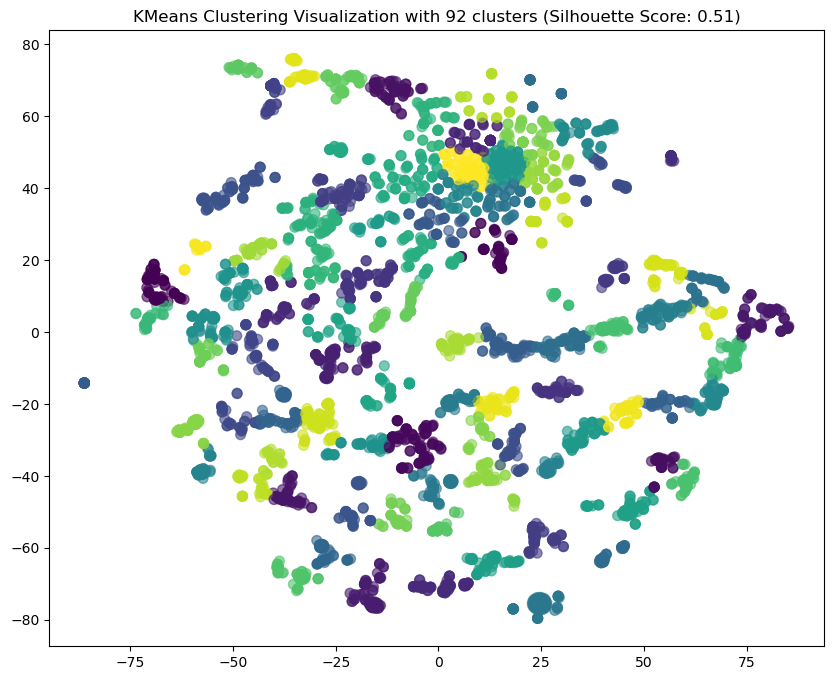

KMeans Clustering: Number of clusters = 92, Silhouette Score = 0.5095233917236328


In [43]:
from sklearn.cluster import KMeans

# Function to apply KMeans clustering and visualize the result
def apply_kmeans_and_visualize(reduced_data, n_clusters):
    # Apply KMeans Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_data)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)

    # Visualize the clustering result
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.6)
    plt.title(f"KMeans Clustering Visualization with {n_clusters} clusters (Silhouette Score: {silhouette_avg:.2f})")
    plt.show()

    return n_clusters, silhouette_avg, cluster_labels

n_clusters_kmeans, score_kmeans, labels_kmeans = apply_kmeans_and_visualize(reduced_data_tsne, n_clusters=92)
print("KMeans Clustering: Number of clusters = {}, Silhouette Score = {}".format(n_clusters_kmeans, score_kmeans))

In [41]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming katz_similarity_matrix_normalized is loaded

# Define the dimensionality reduction algorithm for t-SNE
tsne = TSNE(n_components=2)

# Perform dimension reduction for t-SNE
# Please replace 'katz_similarity_matrix_normalized' with your actual normalized Katz similarity matrix
reduced_data_tsne = tsne.fit_transform(katz_similarity_matrix_normalized)

# Function to evaluate clustering and visualize the result
def evaluate_and_visualize_clustering(reduced_data, max_clusters):
    best_score = -1
    best_n_clusters = 0
    best_labels = None

    for n_clusters in range(2, max_clusters + 1):
        # Apply clustering algorithm - example with KMeans
        clustering = KMeans(n_clusters=n_clusters)
        cluster_labels = clustering.fit_predict(reduced_data)
        
        # Calculate silhouette score
        silhouette_avg = silhouette_score(reduced_data, cluster_labels)
        #print(f"For n_clusters = {n_clusters}, The average silhouette_score is: {silhouette_avg}")

        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_n_clusters = n_clusters
            best_labels = cluster_labels

    # Visualize the best clustering result
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=best_labels, cmap='viridis', s=50, alpha=0.6)
    plt.title(f"t-SNE visualization with {best_n_clusters} clusters (Silhouette Score: {best_score:.2f})")
    plt.show()

    return best_n_clusters, best_score, best_labels

# Evaluate clustering on t-SNE reduced data and visualize the best result
best_n_clusters_tsne, best_score_tsne, best_labels_tsne = evaluate_and_visualize_clustering(reduced_data_tsne, max_clusters = 1000)

# Output the best result for t-SNE
print("t-SNE: Best number of clusters = {}, Silhouette Score = {}".format(
    best_n_clusters_tsne, best_score_tsne))

c:\Users\ycy6y\.conda\envs\pathway_siamese_network\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ycy6y\.conda\envs\pathway_siamese_network\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ycy6y\.conda\envs\pathway_siamese_network\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ycy6y\.conda\envs\pathway_siamese_network\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` expl

KeyboardInterrupt: 

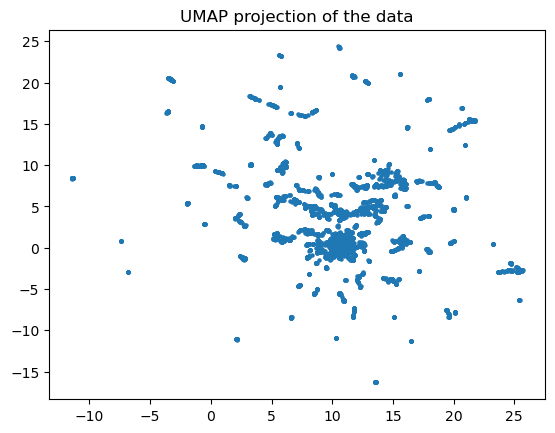

For n_clusters = 2, The average silhouette_score is: 0.4348231852054596
For n_clusters = 3, The average silhouette_score is: 0.3795599937438965
For n_clusters = 4, The average silhouette_score is: 0.3919788599014282
For n_clusters = 5, The average silhouette_score is: 0.38043850660324097
For n_clusters = 6, The average silhouette_score is: 0.4027847349643707
For n_clusters = 7, The average silhouette_score is: 0.4223000705242157
For n_clusters = 8, The average silhouette_score is: 0.42850178480148315
For n_clusters = 9, The average silhouette_score is: 0.42069053649902344
For n_clusters = 10, The average silhouette_score is: 0.4179673194885254
For n_clusters = 11, The average silhouette_score is: 0.42816102504730225
For n_clusters = 12, The average silhouette_score is: 0.46521198749542236
For n_clusters = 13, The average silhouette_score is: 0.4575631320476532
For n_clusters = 14, The average silhouette_score is: 0.46909770369529724
For n_clusters = 15, The average silhouette_score is:

KeyboardInterrupt: 

In [32]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming katz_similarity_matrix_normalized is your precomputed similarity matrix
# Fit UMAP
mapper = umap.UMAP(metric='cosine', random_state=42, low_memory=True).fit(katz_similarity_matrix_normalized)

# Visualization
umap_embeddings = mapper.embedding_
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=5)
plt.title("UMAP projection of the data")
plt.show()

# Determine the optimal number of clusters
max_clusters = 1000  # Adjust as needed
best_score = -1
best_n_clusters = 0

for n_clusters in range(2, max_clusters + 1):
    # Specify n_init explicitly to suppress the warning
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(umap_embeddings)
    score = silhouette_score(umap_embeddings, cluster_labels)

    print(f"For n_clusters = {n_clusters}, The average silhouette_score is: {score}")

    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print("Best number of clusters:", best_n_clusters)

c:\Users\ycy6y\.conda\envs\pathway_siamese_network\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


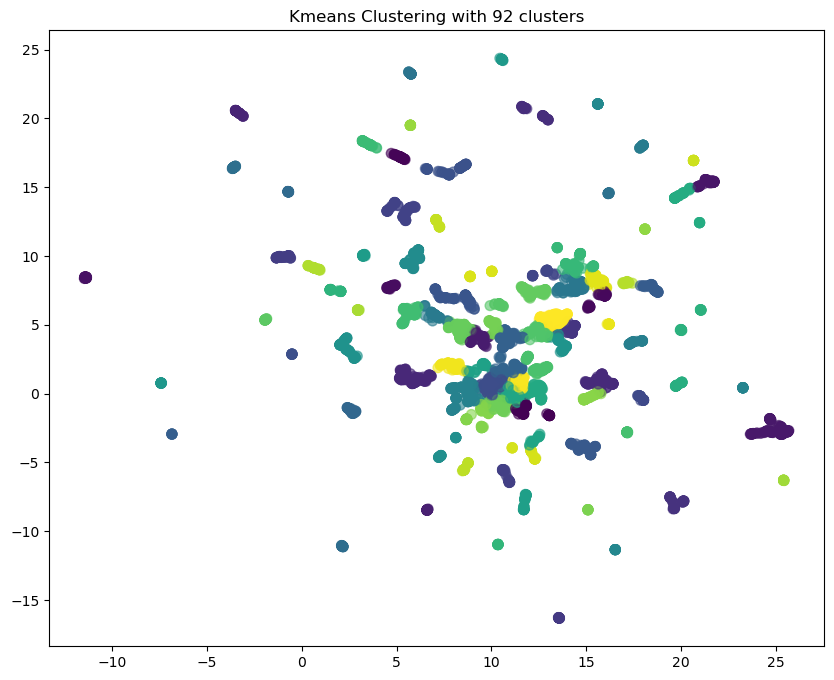

c:\Users\ycy6y\.conda\envs\pathway_siamese_network\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


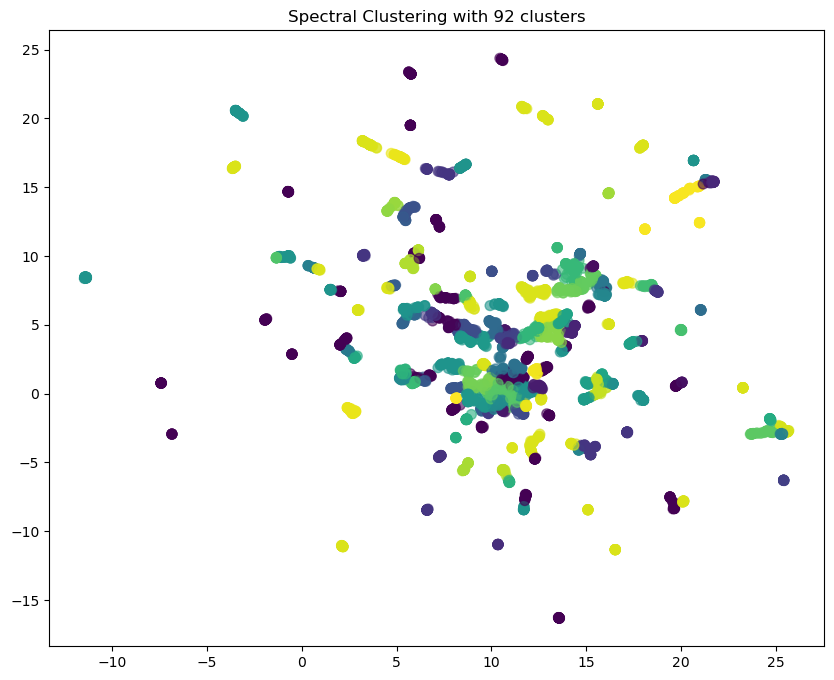

In [44]:
from sklearn.cluster import SpectralClustering

# Function to apply a clustering algorithm and visualize the result
def apply_clustering_and_visualize(embeddings, n_clusters, clustering_method):
    # Apply the chosen clustering method
    if clustering_method == 'kmeans':
        clustering = KMeans(n_clusters=n_clusters, random_state=42)
    elif clustering_method == 'spectral':
        clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    else:
        raise ValueError("Invalid clustering method")

    cluster_labels = clustering.fit_predict(embeddings)

    # Visualize the clustering result
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.6)
    plt.title(f"{clustering_method.title()} Clustering with {n_clusters} clusters")
    plt.show()

    return cluster_labels

# Perform clustering using both KMeans and Spectral Clustering
n_clusters = 92

# UMAP embeddings
umap_embeddings = mapper.embedding_

# Clustering with KMeans
labels_kmeans = apply_clustering_and_visualize(umap_embeddings, n_clusters, 'kmeans')

# Clustering with Spectral Clustering
labels_spectral = apply_clustering_and_visualize(umap_embeddings, n_clusters, 'spectral')


In [39]:
# Clustering with KMeans
optimal_n_clusters = 253
kmeans = KMeans(n_clusters=optimal_n_clusters, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(umap_embeddings)

gene_names = list(MG.nodes())
gene_cluster_pairs = list(zip(gene_names, cluster_labels))

import csv

# Read the existing CSV file
existing_data = {}
with open('gene_cluster_assignments.csv', mode='r') as file:
    reader = csv.reader(file)
    header = next(reader)  # Skip the header
    for row in reader:
        gene = row[0]
        existing_data[gene] = row

# Add UMAP-KMeans cluster assignments
for gene, umap_cluster in gene_cluster_pairs:
    if gene in existing_data:
        existing_data[gene].append(umap_cluster)

# Save the updated data to a new CSV file
with open('updated_gene_cluster_assignments.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header + ['UMAP_KMeans_Cluster'])
    for gene, row in existing_data.items():
        writer.writerow(row)


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class Autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_size)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(embedding_size, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def get_embedding(self, x):
        return self.encoder(x)
    
from torch.utils.data import Dataset, DataLoader
import torch

class MatrixDataset(Dataset):
    def __init__(self, matrix):
        self.matrix = torch.tensor(matrix, dtype=torch.float32)  # Convert matrix to PyTorch tensor

    def __len__(self):
        return 1  # The dataset has only one item (the entire matrix)

    def __getitem__(self, idx):
        return self.matrix

# Convert your similarity matrix to a PyTorch tensor
similarity_tensor = torch.Tensor(katz_similarity_matrix_normalized)

# Example usage
dataset = MatrixDataset(katz_similarity_matrix_normalized)
dataloader = DataLoader(dataset, batch_size=1)  # Batch size of 1 since the entire matrix is one batch

# Parameters
input_size = similarity_tensor.shape[1]
embedding_size = 64  # Adjust the embedding size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize and move the model to the correct device
autoencoder = Autoencoder(input_size, embedding_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    for inputs in dataloader:
        inputs = inputs.to(device)  # Ensure inputs are on the same device
        optimizer.zero_grad()
        outputs = autoencoder(inputs[0])  # Process the inputs through the autoencoder
        loss = criterion(outputs, inputs[0])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}')

Using device: cuda
Epoch [1/50], Loss: 0.0035
Epoch [2/50], Loss: 0.0030
Epoch [3/50], Loss: 0.0025
Epoch [4/50], Loss: 0.0022
Epoch [5/50], Loss: 0.0019
Epoch [6/50], Loss: 0.0016
Epoch [7/50], Loss: 0.0014
Epoch [8/50], Loss: 0.0012
Epoch [9/50], Loss: 0.0010
Epoch [10/50], Loss: 0.0008
Epoch [11/50], Loss: 0.0007
Epoch [12/50], Loss: 0.0006
Epoch [13/50], Loss: 0.0005
Epoch [14/50], Loss: 0.0004
Epoch [15/50], Loss: 0.0003
Epoch [16/50], Loss: 0.0003
Epoch [17/50], Loss: 0.0002
Epoch [18/50], Loss: 0.0002
Epoch [19/50], Loss: 0.0002
Epoch [20/50], Loss: 0.0002
Epoch [21/50], Loss: 0.0001
Epoch [22/50], Loss: 0.0001
Epoch [23/50], Loss: 0.0001
Epoch [24/50], Loss: 0.0001
Epoch [25/50], Loss: 0.0001
Epoch [26/50], Loss: 0.0000
Epoch [27/50], Loss: 0.0000
Epoch [28/50], Loss: 0.0000
Epoch [29/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0000
Epoch [31/50], Loss: 0.0000
Epoch [32/50], Loss: 0.0000
Epoch [33/50], Loss: 0.0000
Epoch [34/50], Loss: 0.0000
Epoch [35/50], Loss: 0.0000
Epoch [36/

In [38]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Function to compute Katz similarity matrix for the validation set
def compute_katz_for_validation(csv_file):
    # Reuse the functions you already defined
    G = build_multigraph_from_csv(csv_file)
    katz_matrix = compute_katz_similarity(G)
    return katz_matrix / np.max(katz_matrix)

# Load and preprocess validation data
val_csv_file_path = 'relations_val_final.csv'  # Path to the validation CSV file
val_katz_similarity_matrix = compute_katz_for_validation(val_csv_file_path)

# Convert to PyTorch tensor and create DataLoader for validation data
val_tensor = torch.tensor(val_katz_similarity_matrix, dtype=torch.float32)
val_dataset = TensorDataset(val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=1024)  # You can adjust the batch size

# Validation loop
autoencoder.eval()  # Set the model to evaluation mode
total_val_loss = 0

with torch.no_grad():
    for inputs in val_dataloader:
        inputs = inputs[0].to(device)  # [0] to get the tensor from the batch
        outputs = autoencoder(inputs)
        val_loss = criterion(outputs, inputs)
        total_val_loss += val_loss.item()

average_val_loss = total_val_loss / len(val_dataloader)
print(f'Average Validation Loss: {average_val_loss:.4f}')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x1464 and 4816x128)

In [4]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering

# Function to perform spectral clustering and calculate silhouette score
def spectral_clustering_and_silhouette(n_clusters, similarity_matrix):
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
    cluster_labels = clustering.fit_predict(similarity_matrix)
    silhouette_avg = silhouette_score(similarity_matrix, cluster_labels)
    return silhouette_avg, cluster_labels

# Determine the range for the number of clusters
max_clusters = 10  # You can adjust this based on your specific data
best_score = -1
best_n_clusters = 0
best_labels = None

# Iterate over the range and compute silhouette scores
for n_clusters in range(2, max_clusters + 1):
    score, labels = spectral_clustering_and_silhouette(n_clusters, katz_similarity_matrix_normalized)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", score)

    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
        best_labels = labels

print("Best number of clusters:", best_n_clusters)
# best_labels now contains the cluster assignments for each node in the graph


For n_clusters = 2 The average silhouette_score is : -0.40349379840467137
For n_clusters = 3 The average silhouette_score is : -0.4674577084108631
For n_clusters = 4 The average silhouette_score is : -0.7134615344998695
For n_clusters = 5 The average silhouette_score is : -0.6045269143064944
For n_clusters = 6 The average silhouette_score is : -0.45361819803118486
For n_clusters = 7 The average silhouette_score is : -0.4187089178808092
For n_clusters = 8 The average silhouette_score is : -0.4661114950098365
For n_clusters = 9 The average silhouette_score is : -0.5347590660250885
For n_clusters = 10 The average silhouette_score is : -0.4484325736529439
Best number of clusters: 2


In [5]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh
from scipy.sparse.csgraph import laplacian as csgraph_laplacian

# Step 1: Construct Normalized Laplacian Matrix
L = csgraph_laplacian(katz_similarity_matrix_normalized, normed=True)

# Step 2: Compute the Eigenvalues and Eigenvectors
num_clusters = 3  # replace with your choice or method to determine
eigenvalues, eigenvectors = eigsh(L, k=num_clusters, which='SM')

# Step 3: Dimensionality Reduction
X = eigenvectors

# Step 4: K-Means Clustering
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(X)

# clusters now holds the cluster assignment for each node in your graph


c:\Users\ycy6y\.conda\envs\pathway_siamese_network\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
from sklearn.cluster import SpectralClustering
import numpy as np

def apply_spectral_clustering(similarity_matrix, n_clusters):
    # Apply spectral clustering to the similarity matrix
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
    cluster_labels = sc.fit_predict(similarity_matrix)
    return cluster_labels

def determine_optimal_clusters(similarity_matrix, max_clusters=4000):
    # Use the eigengap heuristic to determine the optimal number of clusters
    eigenvalues, _ = np.linalg.eigh(similarity_matrix)
    eigenvalues = sorted(eigenvalues, reverse=True)
    max_gap = 0
    optimal_k = 1
    for k in range(2, max_clusters):
        gap = eigenvalues[k-1] - eigenvalues[k]
        if gap > max_gap:
            max_gap = gap
            optimal_k = k
    return optimal_k

# Assuming katz_similarity_matrix_normalized is your similarity matrix
# Determine the optimal number of clusters
optimal_k = determine_optimal_clusters(katz_similarity_matrix_normalized)

print(f"Optimal number of clusters: {optimal_k}")

# Apply spectral clustering with the optimal number of clusters
cluster_labels = apply_spectral_clustering(katz_similarity_matrix_normalized, optimal_k)

# cluster_labels now contains the cluster assignment for each node


Optimal number of clusters: 2


KeyboardInterrupt: 

In [7]:
import os
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering

# Set OMP_NUM_THREADS to avoid memory leak warning on Windows
os.environ["OMP_NUM_THREADS"] = "15"  # Adjust as needed

def make_symmetric(matrix):
    return (matrix + matrix.T) / 2

def ensure_connectivity(matrix):
    return matrix + np.min(matrix[matrix > 0]) * 0.01

# Adjusting the similarity matrix
symmetric_similarity_matrix = make_symmetric(katz_similarity_matrix_normalized)
connected_similarity_matrix = ensure_connectivity(symmetric_similarity_matrix)

range_n_clusters = list(range(2, 4823))  # Adjust this range based on your dataset and resources
best_score = -1
best_n_clusters = 0

for n_clusters in range_n_clusters:
    clusterer = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
    cluster_labels = clusterer.fit_predict(connected_similarity_matrix)
    silhouette_avg = silhouette_score(connected_similarity_matrix, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters

print("Best number of clusters:", best_n_clusters)


For n_clusters = 2 The average silhouette_score is : -0.3850230208601056
For n_clusters = 3 The average silhouette_score is : -0.5641763461271904
For n_clusters = 4 The average silhouette_score is : -0.6428388768578519
For n_clusters = 5 The average silhouette_score is : -0.585696289103794
For n_clusters = 6 The average silhouette_score is : -0.4659191963326206
For n_clusters = 7 The average silhouette_score is : -0.5426879801061377
For n_clusters = 8 The average silhouette_score is : -0.6662189420383461
For n_clusters = 9 The average silhouette_score is : -0.5839502814072111
For n_clusters = 10 The average silhouette_score is : -0.4179429147223848
For n_clusters = 11 The average silhouette_score is : -0.43921944098773136
For n_clusters = 12 The average silhouette_score is : -0.5713462122569697
For n_clusters = 13 The average silhouette_score is : -0.4772703568203711
For n_clusters = 14 The average silhouette_score is : -0.6964637645786289
For n_clusters = 15 The average silhouette_sco

KeyboardInterrupt: 